In [1]:
# %matplotlib notebook
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import skimage
from skimage import io
from skimage.viewer import ImageViewer

/home/rainsong/miniconda3/envs/cg/lib/python3.7/site-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


In [2]:
def get_neighs(im, seed_x, seed_y, visited):
    neighs = [
        (seed_x + 1, seed_y),
        (seed_x - 1, seed_y),
        (seed_x, seed_y + 1),
        (seed_x, seed_y - 1),
        (seed_x + 1, seed_y + 1),
        (seed_x + 1, seed_y - 1),
        (seed_x - 1, seed_y + 1),
        (seed_x - 1, seed_y - 1),
    ]
    neighs = [n for n in neighs if n[0] >= 0 and n[0] < im.shape[0] and n[1] >= 0 and n[1] < im.shape[1]]
    neighs = [n for n in neighs if n not in visited]
    return neighs

def expand_region(im, seed_x, seed_y):
    in_region = []
    visited = set()
    
    to_visit = [(seed_x, seed_y)]
    while len(to_visit) > 0:
        seed_x, seed_y = to_visit.pop()
        neighs_not_visited = get_neighs(im, seed_x, seed_y, visited)
        for n in neighs_not_visited:
            if im[n[0], n[1], 0] == im[seed_x, seed_y, 0]:
                visited.add(n)
                in_region.append(n)
                to_visit.append(n)

    return in_region

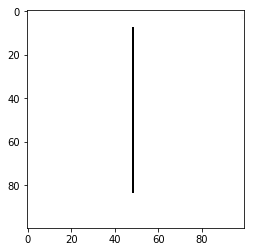

In [3]:
horizontal_im = io.imread('./lines/horizontal.bmp')
horizontal_im2 = io.imread('./lines/horizontal2.bmp')
vertical_im = io.imread('./lines/vertical.bmp')
diagonal_im = io.imread('./lines/inclinada.bmp')
diagonal_im2 = io.imread('./lines/inclinada2.bmp')


f, axarr = plt.subplots(1,1)
plt.imshow(vertical_im)

In [4]:
from enum import Enum
class Direction(Enum):
    HORIZONTAL = 1
    VERTICAL = 2
    DIAGONAL = 3

def find_deviations(im, threshold = 5):
    non_blank_pxs = np.array(np.where(im[:, :, 0] < 240))
    y, x = non_blank_pxs[:, 0]
    pxs = np.array(expand_region(im, y, x))
    return (
        pxs[:, 0].std(),
        pxs[:, 1].std()
    )

def find_line_rotation(im, threshold=5):
    x_std_dev, y_std_dev = find_deviations(im)
#     print(x_std_dev, y_std_dev)
    
    if(x_std_dev < threshold):
        return Direction.HORIZONTAL
    
    if(y_std_dev < threshold):
        return Direction.VERTICAL
    
    return Direction.DIAGONAL

print(find_line_rotation(horizontal_im))

print(find_line_rotation(horizontal_im2))

print(find_line_rotation(vertical_im))

print(find_line_rotation(diagonal_im))

print(find_line_rotation(diagonal_im2))

Direction.HORIZONTAL
Direction.HORIZONTAL
Direction.VERTICAL
Direction.DIAGONAL
Direction.DIAGONAL


Text(0, 0.5, 'Direction.DIAGONAL')

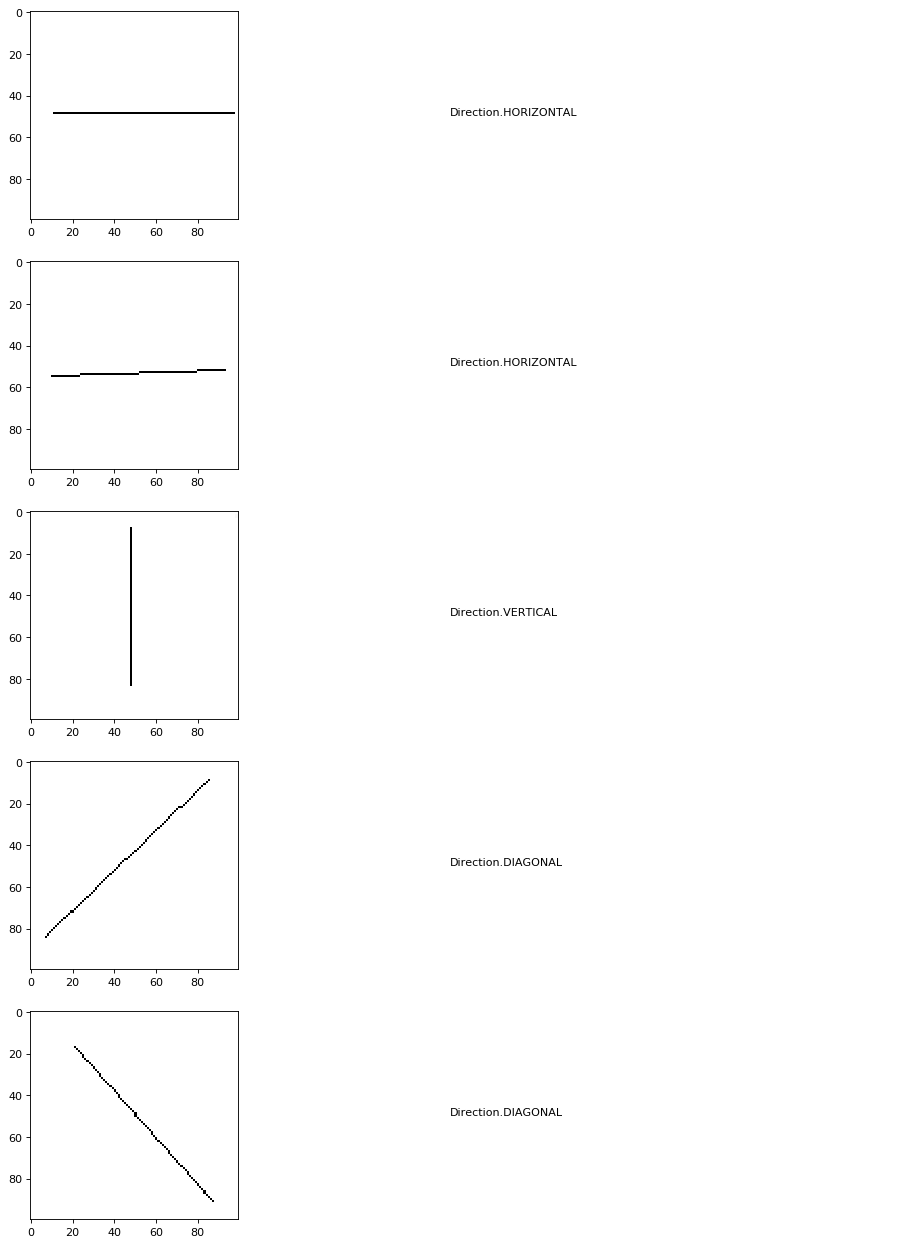

In [79]:
f, axarr = plt.subplots(5, 2, figsize=(16, 20), dpi=80)

axarr[0][1].axis('off')
axarr[1][1].axis('off')
axarr[2][1].axis('off')
axarr[3][1].axis('off')
axarr[4][1].axis('off')


axarr[0][0].imshow(horizontal_im)
axarr[0][1].text(0, 0.5, find_line_rotation(horizontal_im))

axarr[1][0].imshow(horizontal_im2)
axarr[1][1].text(0, 0.5, find_line_rotation(horizontal_im2))

axarr[2][0].imshow(vertical_im)
axarr[2][1].text(0, 0.5, find_line_rotation(vertical_im))

axarr[3][0].imshow(diagonal_im)
axarr[3][1].text(0, 0.5, find_line_rotation(diagonal_im))

axarr[4][0].imshow(diagonal_im2)
axarr[4][1].text(0, 0.5, find_line_rotation(diagonal_im2))